## Импорт библиотек и необходимые параметры

In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
from scripts.create_nab_dataset import create_nab_data
from scripts.create_country_df import get_country_df
from compress.sprintz_encode import compress_sprintz, decompress_sprintz, get_compress_info_sprintz
from compress.bypass import spatial_clustering
from compress.general_functions import get_errors, get_geo_dict, create_geo_plot
from compress.xor_encode import xor_compress_df, get_compress_info_xor, decompress_xor_df
from compress.lz4_encode import LZ4_compress_df, LZ4_decompress_df, get_compress_info_lz4
from compress.spatial_lz4 import spatial_clustering_PCA_LZ4, spatial_lz4_decompress, get_compress_info_spatial_PCA_LZ4
from compress.spatial_xor import spatial_clustering_xor, spatial_XOR_decompress, get_compress_info_spatial_xor
from compress.spatial_sprintz import spatial_clustering_sprintz, spatial_sprintz_decompress, get_compress_info_spatial_sprintz
from compress.sz3_encode import compress_sz3_df, decompress_sz3, get_compress_info_sz3, compress_sz3_all
from compress.cnn_encode import compress_cnn_sz3, decomress_cnn_sz3, get_compress_info_cnn_sz3, compress_cnn_cluster

In [2]:
table_params = [{
                'selector': 'caption',
                'props': [
                    ('color', 'Blue'),
                    ('font-size', '16pt'),
                    ('font-weight', 'bold'),
                    ('text-align', 'center'),
                    ('caption-side', 'top'),
                    ('padding', '10px')
                ]
            },
            {
                'selector': 'th',
                'props': [('font-size', '14pt')]
            }]

## Загрузка тестовых данных

Создание датасета NAB.

In [4]:
df_speed = create_nab_data()
df_speed.sample(2)

,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5
276,86,92,81,91,85
32,69,91,97,94,96


Создание датасета country_df и загрузка его геоданных.

In [5]:
df_wind, wind_geo_dict= get_country_df()
df_wind.sample(2)

,sensor_0,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5
3276,0.433566,0.372340,0.674759,0.600892,0.330922,0.288530
1674,0.401399,0.319432,0.497202,0.357267,0.438800,0.326397


## Геоданные

Реализована функция get_geo_dict, для создания словаря со случайными значениями.

sensor_0: [2.4365216711741304, 1.179891201834797]
sensor_1: [2.1216869503795213, 5.083246952091311]
sensor_2: [5.828487169956302, 0.387565612401372]
sensor_3: [2.694752895643201, 2.370577461751891]
sensor_4: [5.3321381249992115, 4.009741017037938]


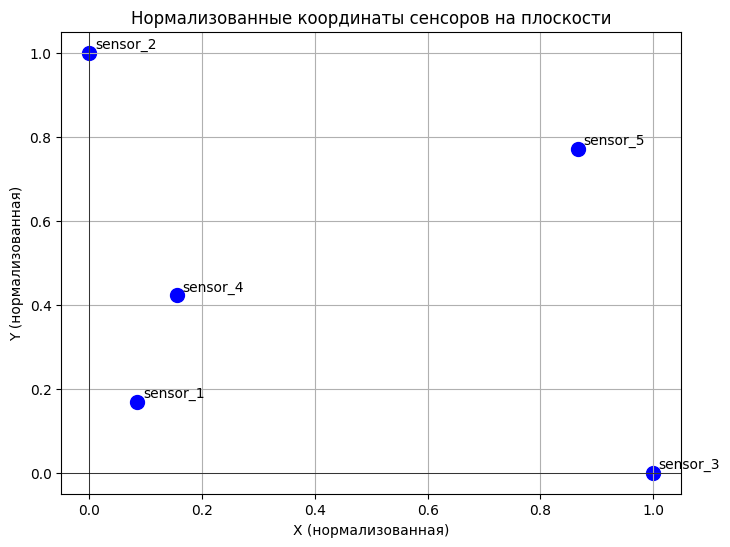

In [6]:
speed_geo_dict = get_geo_dict(df_speed)
create_geo_plot(speed_geo_dict)

## Анализ тестовых данных

### NAB dataset

In [7]:
df_speed.describe()

,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5
count,500.000000,500.000000,500.000000,500.000000,500.000000
mean,82.126000,81.538000,81.862000,81.786000,82.222000
std,8.404963,9.247897,8.155488,8.913085,8.983659
min,43.000000,28.000000,53.000000,29.000000,20.000000
25%,77.000000,76.000000,77.000000,76.000000,77.000000
50%,83.000000,82.000000,82.000000,82.000000,83.000000
75%,87.000000,88.000000,87.000000,88.000000,88.000000
max,109.000000,103.000000,106.000000,106.000000,105.000000


Все значения положительны и не больше 106.

In [8]:
corr_wind = df_speed.corr()
styled_corr = corr_wind.style.set_caption("Correlation matrix of NAB Dataset") \
                                  .background_gradient(cmap='coolwarm') \
                                  .set_properties(**{'font-size': '14pt'}) \
                                  .set_table_styles(table_params)
display(styled_corr)

,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5
sensor_1,1.000000,0.216599,0.170231,0.160731,0.129970
sensor_2,0.216599,1.000000,0.238876,0.241704,0.254247
sensor_3,0.170231,0.238876,1.000000,0.342827,0.135786
sensor_4,0.160731,0.241704,0.342827,1.000000,0.326703
sensor_5,0.129970,0.254247,0.135786,0.326703,1.000000


Для датасета NAB явно видно, что столбцы не коррелируют. Рассмотрим датасет Emhires.

### Emhires dataset

In [9]:
df_wind.describe()

,sensor_0,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5
count,5371.000000,5371.000000,5371.000000,5371.000000,5371.000000,5371.000000
mean,0.227920,0.200216,0.250895,0.226237,0.210789,0.170282
std,0.183147,0.194221,0.228161,0.186192,0.204030,0.158362
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.071329,0.035002,0.043961,0.067200,0.037736,0.035301
50%,0.186014,0.139327,0.182703,0.176465,0.142235,0.121945
75%,0.370629,0.323170,0.428663,0.364866,0.348337,0.278338
max,0.683916,0.783491,0.871451,0.709350,0.791937,0.655671


Все значения неотрицательны и в промежутке от 0 до 1.

In [10]:
corr_wind = df_wind.corr()
styled_corr_wind = corr_wind.style.set_caption("Correlation matrix of Emhires Dataset") \
                                  .background_gradient(cmap='coolwarm') \
                                  .set_properties(**{'font-size': '14pt'}) \
                                  .set_table_styles(table_params)

# Отображение матрицы корреляции
display(styled_corr_wind)

,sensor_0,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5
sensor_0,1.000000,0.692844,0.718031,0.858738,0.901123,0.844601
sensor_1,0.692844,1.000000,0.533855,0.723919,0.705373,0.862921
sensor_2,0.718031,0.533855,1.000000,0.637662,0.685302,0.661292
sensor_3,0.858738,0.723919,0.637662,1.000000,0.772007,0.839008
sensor_4,0.901123,0.705373,0.685302,0.772007,1.000000,0.884198
sensor_5,0.844601,0.862921,0.661292,0.839008,0.884198,1.000000


Видим, что некоторые ряды имеют сильную корреляцию больше 0.84.

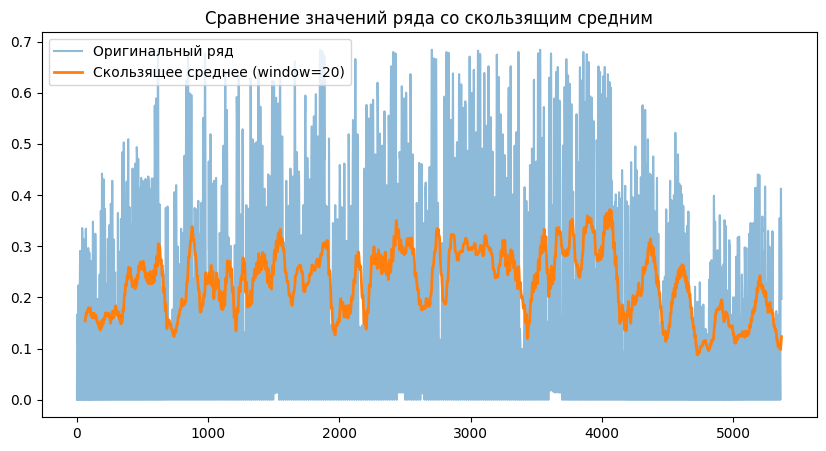

In [11]:
rolling_mean = df_wind.sensor_0.rolling(window=64).mean()
plt.figure(figsize=(10,5))
plt.plot(df_wind.sensor_0.values, label="Оригинальный ряд", alpha=0.5)
plt.plot(rolling_mean, label="Скользящее среднее (window=20)", linewidth=2)
plt.legend()
plt.title("Сравнение значений ряда со скользящим средним")
plt.show()

Видим, что среднее крайне отличается от реальных значений, что может говорить от резких перепадах и шуме.

Расположение сенсоров датасета country_df на плоскости.

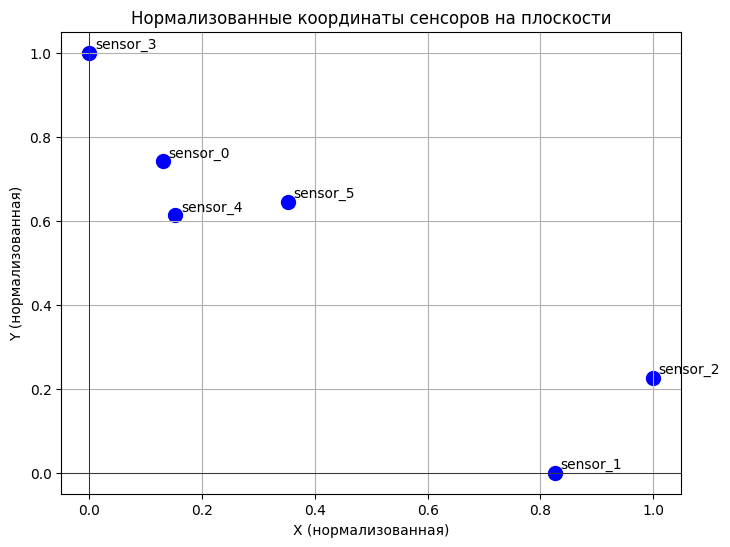

In [12]:
create_geo_plot(wind_geo_dict)

Проверка на кластеризацию обходом.

In [13]:
spatial_clustering(df_wind, wind_geo_dict, 0.84)

{'sensor_0': ['sensor_0', 'sensor_4', 'sensor_3', 'sensor_5'],
 'sensor_1': ['sensor_1'],
 'sensor_2': ['sensor_2']}

## Sprintz

Сожмем и декодируем данные при помощи Sprintz. Используем датасет NAB.

In [14]:
speed_sprintz_res = compress_sprintz(df=df_speed, chunk_size=8)

In [15]:
# Check for equals decodind and original data
decode_res = decompress_sprintz(speed_sprintz_res, num_cols = 5, chunk_size=7)
decode_res.columns = df_speed.columns
print('Данные совпадают после декодирования:', df_speed.equals(decode_res))

Данные совпадают после декодирования: True


In [16]:
comp = get_compress_info_sprintz(df_speed, speed_sprintz_res)

Размер исходных данных: 2179 байт 

Размер сжатых данных: 1973 байт 

Коэффициент сжатия: 1.104


## XOR

Сожмем и декодируем данные с помощью XOR-сжатия.

In [17]:
compressed_df = xor_compress_df(df_wind)
decompressed_df = decompress_xor_df(compressed_df)
decompressed_df.columns = [f'sensor_{i}' for i in range(df_wind.shape[1])]
print('Данные совпадают после декодирования:', decompressed_df.equals(df_wind))

Данные совпадают после декодирования: True


In [18]:
comp = get_compress_info_xor(df_wind, compressed_df)

Размер исходных данных: 257808 байт 

Размер сжатых XOR данных: 249461 байт 

Коэффициент сжатия: 1.033


## LZ4

Сожмем и декодируем данные с помощью LZ4.

In [19]:
compressed_df = LZ4_compress_df(df_wind)

In [20]:
decompressed_df = LZ4_decompress_df(compressed_df)
print('Данные совпадают после декодирования:', decompressed_df.equals(df_wind))

Данные совпадают после декодирования: True


In [21]:
comp = get_compress_info_lz4(df_wind, compressed_df)

Размер исходных данных: 257808 байт 

Размер сжатых данных: 191643 байт 

Коэффициент сжатия: 1.345


## Spatial + XOR

Сожмем и декодируем данные с помощью обходы и последующего XOR-сжатия. Необходимо сократить количество знаков после запятой в датасете country_df до 15.

In [22]:
df = df_wind.round(15).copy()

In [23]:
res = spatial_clustering_xor(df, wind_geo_dict, 0.84)
decompressed_df = spatial_XOR_decompress(res)
print('Check for decode:', decompressed_df.equals(df))

Check for decode: True


In [24]:
comp = get_compress_info_spatial_xor(df, res)

Размер исходных данных: 257808 байт 

Размер сжатых данных: 255656.625 байт 

Коэффициент сжатия: 1.008


## Spatial + Sprintz

Сожмем и декодируем данные с помощью обхода и Sprintz. Для данного алгоритма используем датасет country_df, так как ряды в датасете коррелируют, что необходимо для обхода. Кроме того, приведем данные к целым числам.

In [25]:
df = df_wind*100
df = df.astype(int)

In [26]:
res = spatial_clustering_sprintz(df.copy(), wind_geo_dict, 0.84)

In [27]:
clust_dict = spatial_clustering(
    df, wind_geo_dict, 0.84)
decode_res = spatial_sprintz_decompress(res,
                                        clust_dict)
print('Данные совпадают после декодирования:', df.equals(decode_res))

Данные совпадают после декодирования: True


In [28]:
comp = get_compress_info_spatial_sprintz(df, res)

Размер исходных данных: 16428 байт 

Размер сжатых данных: 42420 байт 

Коэффициент сжатия: 0.387


## Spatial + PCA

Сожмем и декодируем данные с помощью PCA.

In [29]:
res = spatial_clustering_PCA_LZ4(df_wind, wind_geo_dict,0.84)

In [30]:
comp = get_compress_info_spatial_PCA_LZ4(df_wind, res)

Размер исходных данных: 257808 байт 

Размер сжатых данных: 148768 байт 

Коэффициент сжатия: 1.733


In [31]:
clusters = spatial_clustering(df_wind, wind_geo_dict, 0.84)
dec_res = spatial_lz4_decompress(res, clusters)
mse, mape = get_errors(df_wind, dec_res)

MSE: 0.001079 

MAPE: 13.78 % 



## SZ3

Сожмем и декодируем данные с помощью SZ3 раздельно, как если бы каждый сенсор сжимал данные сам.

In [32]:
data_enc = compress_sz3_df(df_wind, 0.03)

In [33]:
comp = get_compress_info_sz3(df_wind, data_enc)

Размер исходных данных: 257808 байт 

Размер сжатых данных: 12635 байт 

Коэффициент сжатия: 20.404


In [34]:
data = df_wind.values.transpose()
shape = [d.shape for d in data]
type = data[0].dtype
data_dec = decompress_sz3(data_enc, shape, type)
get_errors(df_wind, data_dec)

MSE: 0.000271 

MAPE: 20.64 % 



(0.000271, 20.64)

Сожмем и декодируем данные сразу целиком, чтобы убедиться, что коэффициент сжатия SZ3 зависит от размера входных данных.

In [35]:
# compress whole data
data = df_wind.values.transpose()
data_enc = compress_sz3_all(df_wind, 0.03)

In [36]:
comp = get_compress_info_sz3(df_wind, data_enc)

Размер исходных данных: 257808 байт 

Размер сжатых данных: 11523 байт 

Коэффициент сжатия: 22.373


In [37]:
data_dec = decompress_sz3(data_enc, data.shape, data.dtype)
get_errors(df_wind, data_dec)

MSE: 0.000263 

MAPE: 22.64 % 



(0.000263, 22.64)

## SZ3 + CNN

### Без DWT-признаков

Сожмем данные только одного кластера с помощью CNN. Используем для сжатия модели алгоритм zstd. Рассмотрим функцию потерь на большом количестве эпох и качество восстановления.

Время обучения: 354.63 секунд


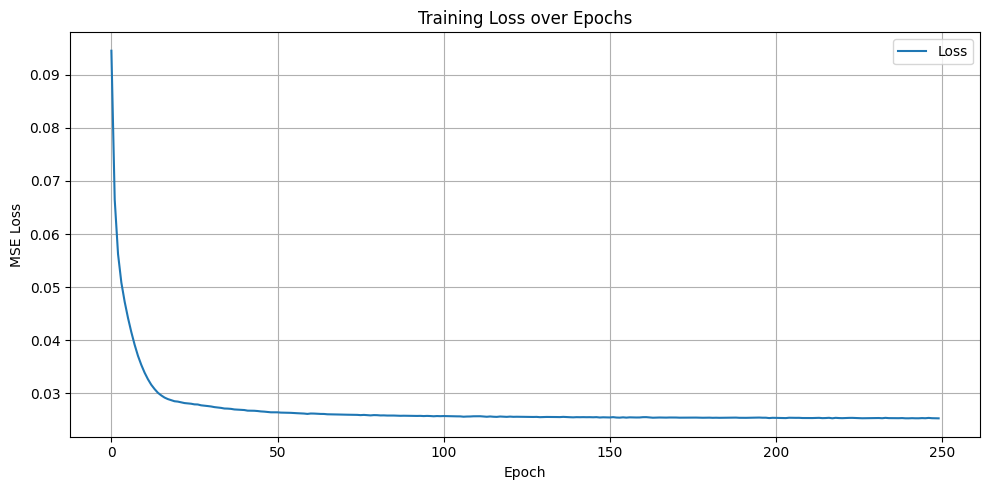

Size of compressed model (bytes): 3624


In [38]:
cluster_enc = {}
cluster_sensors = ['sensor_0', 'sensor_4', 'sensor_3', 'sensor_5'] #выделяем коррелирующие сенсоры кластера
cluster_enc[tuple(cluster_sensors)] = compress_cnn_cluster(df_wind[cluster_sensors], use_dwt=False,
                                                           window_size=64, num_epochs=250, extra_layer=False,
                                                           conv_filter=2, plot_flag=True,
                                                           er_abs_sz3=0.03,  model_compress="zstd")

In [39]:
print('Сжатия кластера \n')
comp = get_compress_info_cnn_sz3(df_wind[cluster_sensors], cluster_enc)

Сжатия кластера 

Размер исходных данных: 171872 байт 

Размер сжатых данных: 6706 байт 

Коэффициент сжатия: 25.63


In [40]:
dec_cluster_df = decomress_cnn_sz3(cluster_enc, (5371,), use_dwt=False, model_compress="zstd")
dec_cluster_df = dec_cluster_df.sort_index(axis=1)

In [41]:
mse, mape = get_errors(df_wind[cluster_sensors].sort_index(axis=1), dec_cluster_df)

MSE: 0.006469 

MAPE: 45.91 % 



Теперь сожмем все данные.

Используем lz4 для сжатия модели.

In [42]:
# Используем LZ4 для сжатия.
enc_df = compress_cnn_sz3(df_wind,
                          wind_geo_dict,
                          cor_lvl=0.84,
                          use_dwt=False,
                          window_size=64,
                          num_epochs=70,
                          extra_layer=False,
                          conv_filter=2,
                          plot_flag=False,
                          er_abs_sz3=0.03,
                          model_compress="lz4")

Время обучения: 108.88 секунд
Size of compressed model (bytes): 4515


In [43]:
comp = get_compress_info_cnn_sz3(df_wind, enc_df)

Размер исходных данных: 257808 байт 

Размер сжатых данных: 12009 байт 

Коэффициент сжатия: 21.468


Используем ZSTD для сжатия модели.ё

In [44]:
enc_df = compress_cnn_sz3(df_wind,
                          wind_geo_dict,
                          cor_lvl=0.84,
                          use_dwt=False,
                          window_size=64,
                          num_epochs=70,
                          extra_layer=False,
                          conv_filter=2,
                          plot_flag=False,
                          er_abs_sz3=0.03,
                          model_compress="zstd")

Время обучения: 115.02 секунд
Size of compressed model (bytes): 3654


In [45]:
comp = get_compress_info_cnn_sz3(df_wind, enc_df)

Размер исходных данных: 257808 байт 

Размер сжатых данных: 11148 байт 

Коэффициент сжатия: 23.126


In [46]:
dec_df = decomress_cnn_sz3(enc_df, (5371,), use_dwt=False)
dec_df = dec_df.sort_index(axis=1)

In [47]:
mse, mape = get_errors(df_wind, dec_df)

MSE: 0.004198 

MAPE: 36.48 % 



### С DWT-признаками

Теперь будем использовать модель, выделяя дополнительные признаки DWT преобразования.

Рассмотрим изменения функции потерь при обучении.

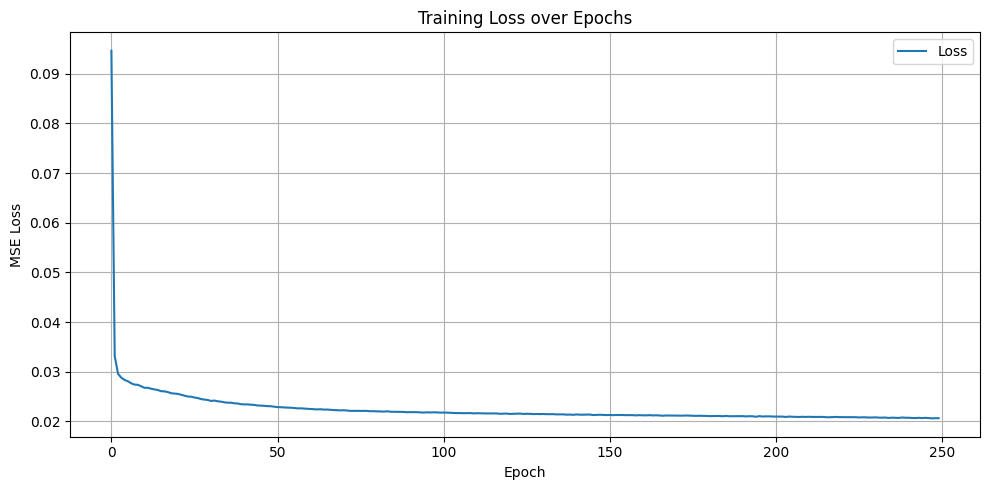

Size of compressed model (bytes): 10272


In [48]:
cluster_enc = {}
cluster_sensors = ['sensor_0', 'sensor_4', 'sensor_3', 'sensor_5'] #выделяем коррелирующие сенсоры
cluster_enc[tuple(cluster_sensors)] = compress_cnn_cluster(df_wind[cluster_sensors], use_dwt=True,
                                                           window_size=64, num_epochs=250, conv_filter=3, plot_flag=True,
                                                           er_abs_sz3=0.03,  model_compress="zstd")

In [49]:
print('Сжатия кластера \n')
comp = get_compress_info_cnn_sz3(df_wind[cluster_sensors], cluster_enc)

Сжатия кластера 

Размер исходных данных: 171872 байт 

Размер сжатых данных: 13354 байт 

Коэффициент сжатия: 12.87


In [50]:
dec_cluster_df = decomress_cnn_sz3(cluster_enc, (5371,), use_dwt=True)
dec_cluster_df = dec_cluster_df.sort_index(axis=1)

In [51]:
mse, mape = get_errors(df_wind[cluster_sensors], dec_cluster_df)

MSE: 0.006438 

MAPE: 44.81 % 



Теперь сожмем все данные.

Применим lz4 для сжатия модели.

In [52]:
#lz4 model compression
enc_df = compress_cnn_sz3(df_wind,
                          wind_geo_dict,
                          cor_lvl=0.84,
                          use_dwt=True,
                          window_size=64,
                          num_epochs=100,
                          conv_filter=3,
                          plot_flag=False,
                          er_abs_sz3=0.03,
                          model_compress="lz4")

Size of compressed model (bytes): 11787


In [53]:
comp = get_compress_info_cnn_sz3(df_wind, enc_df)

Размер исходных данных: 257808 байт 

Размер сжатых данных: 19281 байт 

Коэффициент сжатия: 13.371


Применим ZSTD для сжатия модели.

In [55]:
#zstd model compression
enc_df = compress_cnn_sz3(df_wind,
                          wind_geo_dict,
                          cor_lvl=0.84,
                          use_dwt=True,
                          window_size=64,
                          num_epochs=100,
                          conv_filter=3,
                          plot_flag=False,
                          er_abs_sz3=0.03,
                          model_compress="zstd")

Size of compressed model (bytes): 10266


In [56]:
comp = get_compress_info_cnn_sz3(df_wind, enc_df)

Размер исходных данных: 257808 байт 

Размер сжатых данных: 17760 байт 

Коэффициент сжатия: 14.516


In [57]:
dec_df = decomress_cnn_sz3(enc_df, (5371,), use_dwt=True, model_compress="zstd")
dec_df = dec_df.sort_index(axis=1)

In [58]:
mse, mape = get_errors(df_wind, dec_df)

MSE: 0.003772 

MAPE: 34.54 % 

